# Method descriptions

* **centralized** finds global classifier using the centralized data
* **regularised** learns local classifiers keeping them similar to the neighbors' classifiers
* **local** learns independent local classifiers


In [17]:
# imports
from copy import deepcopy
import numpy as np

from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_basis
from evaluation import central_accuracy, edges
from network import synthetic_graph, true_theta_graph
from optimization import regularized_local_FW, local_FW, global_regularized_local_FW, gd_reg_local_FW, centralized_FW
from related_works import colearning, lafond_FW
from utils import generate_models, generate_samples

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# set graph of nodes with local personalized data
NB_ITER = 100
N = 100
D = 20
NOISE_R = 0.05
random_state = 2017
BETA = 1 # if None, simplex constraint
MU = 1

V, theta_true, cluster_indexes = generate_models(nb_clust=1, nodes_per_clust=N, random_state=random_state)
_, X, Y, X_test, Y_test, max_insts = generate_samples(V, theta_true, D, random_state=random_state, sample_error_rate=NOISE_R)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, V, theta_true, max_insts)

# set monitors for optimization analysis
monitors = {
    'accuracy': [central_accuracy, []],
    'edges': [edges, []],
}

base_clfs = get_basis(n=D+1, d=D+1)

results = {}

In [19]:
nodes_copy = deepcopy(nodes)
results["regularized"] = regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, mu=MU, monitors=monitors)

In [20]:
lafond_nodes = deepcopy(nodes)
lafond_FW(lafond_nodes, base_clfs, beta=BETA, nb_iter=1000, monitors={})
results["lafond"] = central_accuracy(lafond_nodes)

centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["centralized"] = central_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["local"] = central_accuracy(local_nodes)

global_nodes = deepcopy(nodes)
global_regularized_local_FW(global_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["global-reg"] = central_accuracy(global_nodes)

results["colearning"], clf_colearning = colearning(N, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, similarities)

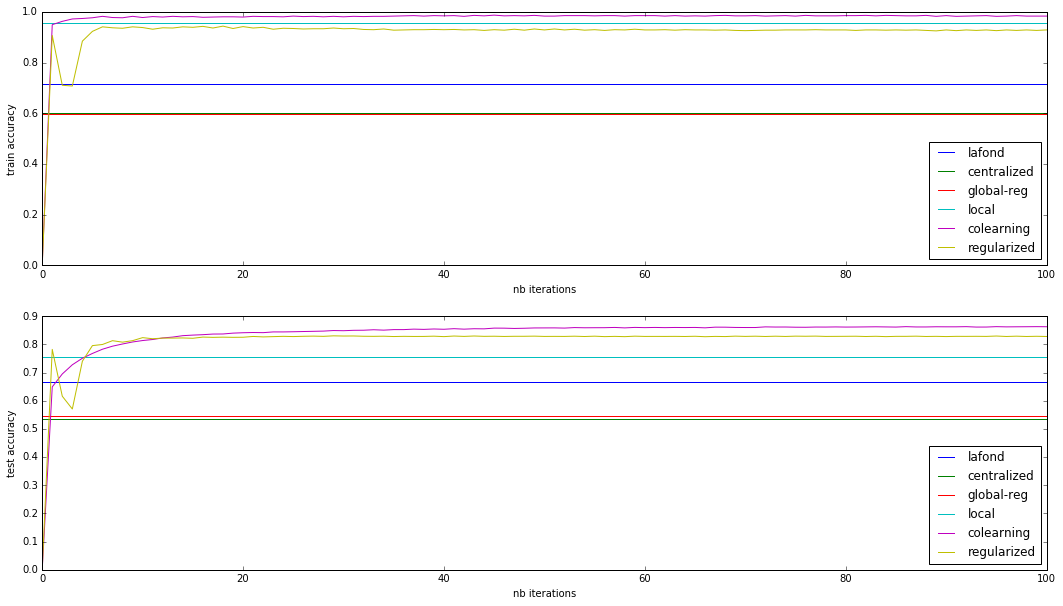

In [21]:
max_iter = 100
plt.figure(1, figsize=(18, 10))

plt.subplot(211)
plt.xlabel('nb iterations')
plt.ylabel('train accuracy')
plt.xlim(0, max_iter)

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [r['accuracy'][0] for r in r_list], label='{}'.format(k))
    except:
        plt.plot(range(NB_ITER+1), [r_list[0]]*(NB_ITER+1), label='{}'.format(k))

plt.legend(loc='lower right')

plt.subplot(212)
plt.xlabel('nb iterations')
plt.ylabel('test accuracy')
plt.xlim(0, max_iter)

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [r['accuracy'][1] for r in r_list], label='{}'.format(k))
    except:
        plt.plot(range(NB_ITER+1), [r_list[1]]*(NB_ITER+1), label='{}'.format(k))

plt.legend(loc='lower right')